In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
device = 'cuda'
from time import time

import losses
from utils import ScatteringProblem

In [2]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 150

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 10
lambd_mmd_for_feature  = 50

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 25
#
exponent_clamping = 2.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [3]:
labels,inputs = utils.read_data('/home/slaskina/simulations', ndim_x_class, ndim_x_features, ndim_y)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(labels[:,3:])
print(scaler.mean_)
labels_new = scaler.transform(labels[:,3:])
labels_new = torch.concatenate((labels[:,:3],torch.from_numpy(labels_new) ), axis=1).type(torch.float32)

[1.70375634 1.68617923 1.70422724 0.1001788  8.56173952 0.04984434
 0.04999   ]


In [5]:
(train_indices, val_indices, test_indices), train_loader, test_loader = utils.create_loaders(inputs, labels_new, batch_size)

In [6]:
class ForwardScatteringConvolutional(nn.Module):
    def __init__(self, N_blocks) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.sequence_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
            #nn.BatchNorm1d(512)
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU(),
            #nn.BatchNorm1d(128)
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            x =  self.sequence_block(x)
        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)

In [7]:
model_simple_conv = ForwardScatteringConvolutional(N_blocks).to(device)

In [8]:
def params_trainable(model):
    params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
    for p in params_trainable:
        p.data = init_scale * torch.randn(p.data.shape).to(device)
    return params_trainable

def optimizer(model):
    optim = torch.optim.Adam(params_trainable(model), lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
    return optim 

gamma = (final_decay)**(1./n_epochs)

def optim_step(optim):
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def save(name, model, optim):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name, model, optim):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [9]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)


def loss_forward_mmd(x_class, x_features, pred):
    pred_class, pred_features = pred[:,:3], pred[:, 3:]
    MMD_class = losses.backward_mmd(x_class, pred_class) 
    MMD_features = losses.backward_mmd(x_features, pred_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
    return lambd_mmd_for_class * torch.mean(MMD_class)+lambd_mmd_for_feature * torch.mean(MMD_features)

def train_epoch(model, optim, i_epoch, loader,  test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for y,x in loader: # because y is  actualy the result of x

        if batch_idx > n_its_per_epoch:
            break

        batch_idx += 1

        x, y = x.to(device), y.to(device)
        x_class, x_features = x[:, :3],x[:, 3:]


        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
     
        pred = model(y).reshape(-1,10)
        loss = loss_forward_mmd(x_class, x_features, pred)
        loss_history.append([loss.item()]) # lisr of lists: list for each batch
        
        if not test:
            loss.backward()
            optim_step(optim)

    if test:
        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train(model, optim, train_loader, test_loader):

    try:
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(model, optim, i_epoch, train_loader) # mean over batches
            test_losses  = train_epoch(model, optim, i_epoch, test_loader, test=True)
            t = np.concatenate([train_losses, test_losses])
            print('Epoch {i_e}: training loss: {tl}, test loss: {testl}'.format(i_e = i_epoch, tl = t[0], testl = t[1]))


    except:
        save(filename_out + '_ABORT',model, optim)
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out,model, optim)


In [10]:
train(model_simple_conv, optimizer(model_simple_conv), train_loader, test_loader)

Epoch 0: training loss: 264.1096816644436, test loss: 258.1001772673234
Epoch 1: training loss: 258.78898974162774, test loss: 256.9388507345448
Epoch 2: training loss: 259.22712651694695, test loss: 257.29669189453125
Epoch 3: training loss: 258.6757732484399, test loss: 257.7008514404297
Epoch 4: training loss: 258.67198944091797, test loss: 257.2488735033118
Epoch 5: training loss: 258.6349323551829, test loss: 256.2823121444039
Epoch 6: training loss: 258.80649157268243, test loss: 257.2216153352157
Epoch 7: training loss: 134.77452920704354, test loss: 5.808359643687373
Epoch 8: training loss: 5.81147844035451, test loss: 5.731447323508885
Epoch 9: training loss: 5.878070883634614, test loss: 5.757130436275316
Epoch 10: training loss: 5.846764977385358, test loss: 5.7928166182144825
Epoch 11: training loss: 5.884648695224669, test loss: 5.659893409065578
Epoch 12: training loss: 5.823143028631443, test loss: 6.043532350788945
Epoch 13: training loss: 5.866262034672062, test loss: 

In [11]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd

In [12]:
def create_table_from_outcome(pred, sampled_inputs):
    df = pd.DataFrame(columns = ['true_shape', 'pred_shape', 'radius','pred_radius'], index = [])
    df['true_shape'] = sampled_inputs[:,:3].argmax(axis=1)
    df['pred_shape'] = pred[:,:3].argmax(axis=1)
    df['radius'] = np.take_along_axis(sampled_inputs[:,3:6],df.true_shape.values.reshape(-1,1), axis=1)
    df['pred_radius'] = np.take_along_axis(pred[:,3:6],df.pred_shape.values.reshape(-1,1), axis=1)
    df['radius_pd'] = sampled_inputs[:,6]
    df['pred_radius_pd'] = pred[:,6]
    df['length'] = sampled_inputs[:,7]
    df['pred_length'] = np.where(df.pred_shape.values ==2, pred[:,7], 0) # only those identified as cylinder should have lengh and pd_length
    df['length_pd'] = sampled_inputs[:,8]
    df['pred_length_pd'] = np.where(df.pred_shape.values ==2, pred[:,8], 0)
    df['volfraction'] = sampled_inputs[:,9]
    df['pred_volfraction'] = np.where(df.pred_shape.values ==1, pred[:,9], 0)
    return df

In [13]:
def make_prediction(labels, model):
    return model(labels)


In [14]:
def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

In [15]:
def outcomes(df, data_name):
    print('Accuracy is {0:.2%}'.format((df.true_shape == df.pred_shape).sum()/len(df)))
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    shapes = ['sphere', 'hardsphere', 'cylinder']
    # shape classified correctly
    correct = [((df.true_shape == 0) & (df.pred_shape == 0)).sum(),((df.true_shape == 1) & (df.pred_shape == 1)).sum(),((df.true_shape == 2) & (df.pred_shape == 2)).sum()]
    wrong = [((df.true_shape == 0) & (df.pred_shape != 0)).sum(),((df.true_shape == 1) & (df.pred_shape != 1)).sum(),((df.true_shape == 2) & (df.pred_shape != 2)).sum()]
    correct = [correct[i]/(correct[i]+ wrong[i])*100 for i in range(len(correct))]
    wrong = [100-correct[i] for i in range(len(wrong))]
    ax = axes[0,0]
    ax.bar(shapes, correct, width=0.35, label='correct', color = 'peachpuff')
    ax.bar(shapes, wrong, width=0.35,bottom=correct, label='misclassified', color = 'plum')
    ax.set_ylabel('correct predictions, %')
    ax.set_title('Shapes predictions')
    ax.text(-0.05, 5, 'correct', rotation = 90)
    ax.text(0.95, 5, 'correct', rotation = 90)
    ax.text(1.95, 5, 'correct', rotation = 90)
    
    ax.text(-0.05, 65, 'misclassified', rotation = 90)
    ax.text(0.95, 65, 'misclassified', rotation = 90)
    ax.text(1.95, 65, 'misclassified', rotation = 90)

    # radius of a correctly identified shapes
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
      
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

    print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
    print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
    print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
        (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))
    #stacked df to create violinplots
    df_stacked = df[df.true_shape ==df.pred_shape].drop(columns = ['pred_shape']).set_index('true_shape').stack().reset_index().rename(columns = {'level_1':'feature', 0:'value'})
    df_stacked.loc[df_stacked.true_shape == 0, 'true_shape'] = "sphere"
    df_stacked.loc[df_stacked.true_shape == 1, 'true_shape'] = "hardsphere"
    df_stacked.loc[df_stacked.true_shape == 2, 'true_shape'] = "cylinder"

    ax = axes[0,1]
    data = df_stacked[(df_stacked.feature == 'radius')|(df_stacked.feature == 'pred_radius')]
    data.loc[data.feature == 'radius', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius distribution for correct shapes')
    ax.set_ylabel("radius, nm")
    ax.set_xlabel("")
    ax.legend()

    ax = axes[0,2]
    data = df_stacked[(df_stacked.feature == 'radius_pd')|(df_stacked.feature == 'pred_radius_pd')]
    data.loc[data.feature == 'radius_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius polidispersity distribution\nfor correct shapes')
    ax.legend()
    ax.set_ylabel("radius pd")
    ax.set_xlabel("")

    # length
    df_stacked = df.set_index(['true_shape', 'pred_shape']).stack().reset_index().rename(columns = {'level_2':'feature', 0:'value'}).assign(y=1)

    ax = axes[1,0]
    data = df_stacked[((df_stacked.feature == 'length')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature",split = True, ax=ax, palette=['peachpuff', 'plum'] )
    ax.set_title('Length distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length, nm")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 4.2, "sampled")
    ax.text(0.2, 4.2, "predicted")
    ax.set_ylim([-.5,6])

    ax = axes[1,1]
    data = df_stacked[((df_stacked.feature == 'length_pd')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length_pd')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False),  x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Length polidispersity distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length pd")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.25, "sampled")
    ax.text(0.2, 0.25, "predicted")
    ax.set_ylim([-0.05, 0.35])

    ax = axes[1,2]
    data = df_stacked[((df_stacked.feature == 'volfraction')&(df_stacked.true_shape ==1))|((df_stacked.feature == 'pred_volfraction')&(df_stacked.pred_shape == 1))]
    data.loc[data.feature == 'volfraction', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_volfraction', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Volume fraction distribution of hardsphere')
    ax.set_xlabel("hardsphere")
    ax.set_ylabel("volumefraction")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.5, "sampled")
    ax.text(0.2, 0.5, "predicted")
    ax.set_ylim([-0.1, 0.7])

    plt.suptitle('{d} Data'.format(d = data_name))

Accuracy is 10.53%
MSE for radius per shape for correctly identified instances as follows: sphere: 0.1577, hardsphere: 13.4888 and cylinder: 2.3851
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0294, hardsphere: 1.4019 and cylinder: 1.5790
MSE for cylinder length for correctly identified instances: 3.7045
MSE for cylinder length polydispersity for correctly identified instances: 4.8033
MSE for cylinder length for correctly identified instances: 0.8611


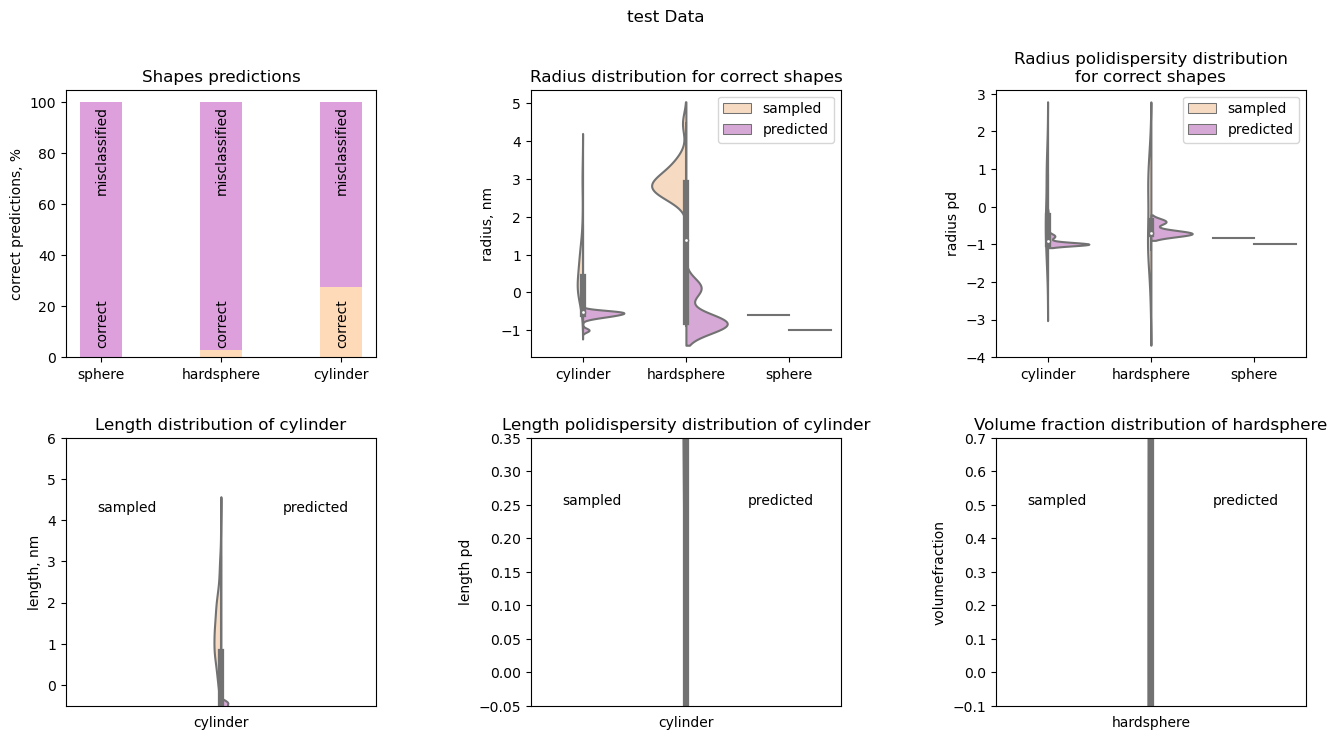

In [16]:
predicted_features = make_prediction(inputs[test_indices], model_simple_conv.to('cpu')).detach().numpy()
df = create_table_from_outcome(predicted_features, labels_new[test_indices])
outcomes(df, 'test')